No of rows in the dataset --> 284807
No of columns in the dataset --> 31


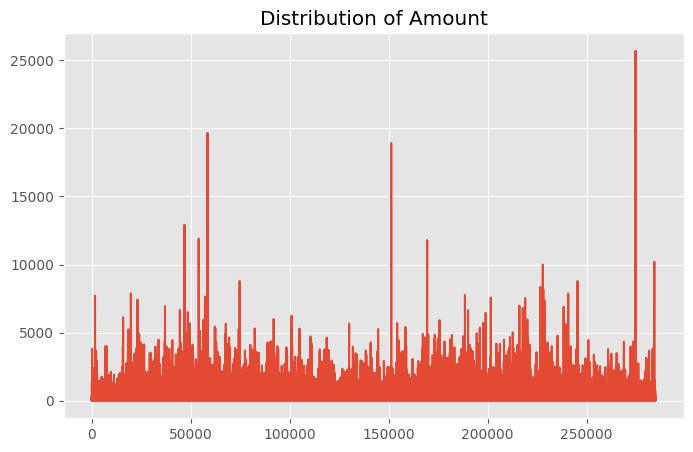

Before SMOTE distribution: [220152    378]
After SMOTE distribution: [220152 220152]


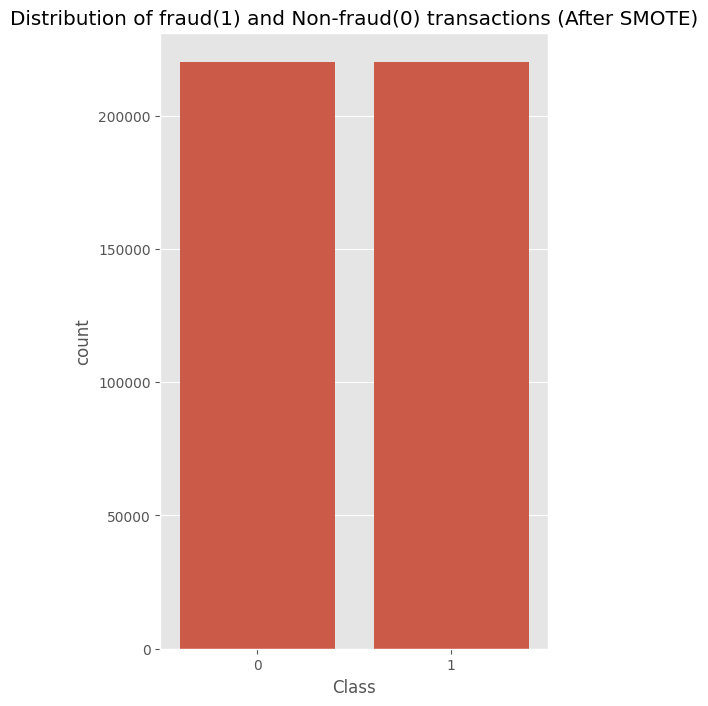


--- Logistic Regression (with SMOTE) Metrics ---
Accuracy:- 97.45%
F1-Score:- 0.11

--- XGBoost (with SMOTE) Metrics ---
Accuracy:- 99.07%
F1-Score:- 0.24
Precision:- 56.89%
Recall:- 91.65%


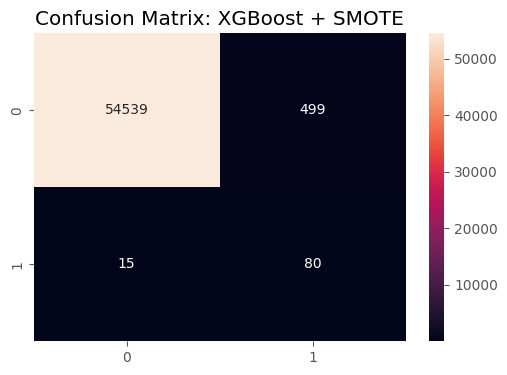

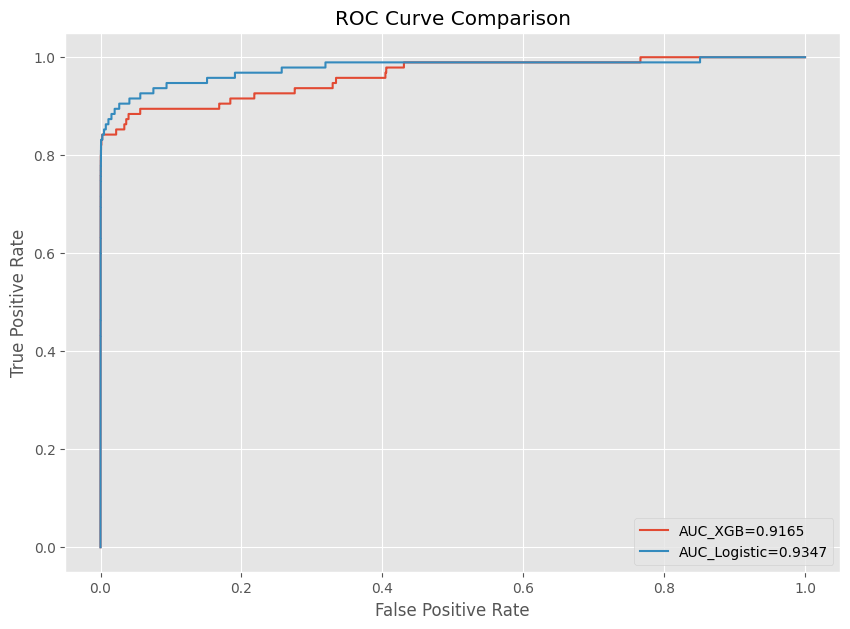

In [29]:
# 1. Install necessary libraries
!pip install -U imbalanced-learn xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score, classification_report, roc_curve, roc_auc_score

# 2. Load the dataset (Assuming the filename is 'dataset.csv')
# If your filename is different, please rename it here
df = pd.read_csv('dataset.csv')

# 3. Initial Data Cleaning
print(f"No of rows in the dataset --> {df.shape[0]}")
print(f"No of columns in the dataset --> {df.shape[1]}")
df.drop(["Time"], axis=1, inplace=True)
df.drop_duplicates(inplace=True)

# 4. Visualization: Amount Distribution (Line Plot)
with plt.style.context(('ggplot')):
    plt.figure(figsize=(8,5))
    plt.title("Distribution of Amount")
    plt.plot(df["Amount"])
    plt.show()

# 5. Feature Scaling and Splitting
sc = StandardScaler()
df.Amount = sc.fit_transform(df.Amount.values.reshape(-1,1))

x = df.drop(["Class"], axis=1)
y = df["Class"]
# Use stratified split to maintain class ratio before oversampling
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42, stratify=y)

# 6. Apply SMOTE for Balancing
print(f"Before SMOTE distribution: {np.bincount(y_train)}")
sm = SMOTE(random_state=42)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)
print(f"After SMOTE distribution: {np.bincount(y_train_res)}")

# 7. Visualization: Class Distribution (Count Plot)
with plt.style.context(('ggplot')):
    plt.figure(figsize=(5,8))
    plt.title("Distribution of fraud(1) and Non-fraud(0) transactions (After SMOTE)")
    sns.countplot(x=y_train_res)
    plt.show()

# 8. Model Training & Metrics: Logistic Regression
model_log = LogisticRegression(max_iter=1000)
model_log.fit(x_train_res, y_train_res)
y_pred_log = model_log.predict(x_test)

print("\n--- Logistic Regression (with SMOTE) Metrics ---")
print(f"Accuracy:- {round(accuracy_score(y_test, y_pred_log)*100, 2)}%")
print(f"F1-Score:- {round(f1_score(y_test, y_pred_log), 2)}")

# 9. Model Training & Metrics: XGBoost
model_xgb = XGBClassifier(max_depth=2)
model_xgb.fit(x_train_res, y_train_res)
y_pred_xgb = model_xgb.predict(x_test)

print("\n--- XGBoost (with SMOTE) Metrics ---")
print(f"Accuracy:- {round(accuracy_score(y_test, y_pred_xgb)*100, 2)}%")
print(f"F1-Score:- {round(f1_score(y_test, y_pred_xgb), 2)}")
print(f"Precision:- {round(precision_score(y_test, y_pred_xgb, average='macro')*100, 2)}%")
print(f"Recall:- {round(recall_score(y_test, y_pred_xgb, average='macro')*100, 2)}%")

# 10. Visualization: Confusion Matrix (Heatmap)
with plt.style.context(('ggplot')):
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d')
    plt.title("Confusion Matrix: XGBoost + SMOTE")
    plt.show()

# 11. Visualization: ROC Curve Comparison
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, model_xgb.predict_proba(x_test)[:,1])
auc_xgb = roc_auc_score(y_test, y_pred_xgb)

fpr_log, tpr_log, _ = roc_curve(y_test, model_log.predict_proba(x_test)[:,1])
auc_log = roc_auc_score(y_test, y_pred_log)

with plt.style.context(('ggplot')):
    plt.figure(figsize=(10,7))
    plt.title("ROC Curve Comparison")
    plt.plot(fpr_xgb, tpr_xgb, label=f"AUC_XGB={auc_xgb:.4f}")
    plt.plot(fpr_log, tpr_log, label=f"AUC_Logistic={auc_log:.4f}")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()